In [284]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.6f}'.format
plt.style.use("seaborn-v0_8")
#from IterativeBase import IterativeBase

In [285]:
class IterativeBase():

    def __init__(self, symbol, start, end, amount, use_spread=True):
        self.end = end
        self.use_spread = use_spread
        self.symbol = symbol
        self.start = start
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.data = self.get_data()
        self.balance_history = pd.DataFrame(columns=['Datetime', 'balance'])

    def get_data(self):
        df = pd.read_csv('eurusd_minute.csv', usecols=['Date', 'Time', 'BC', 'AC'])
        df['Datetime'] = df['Date'] + ' ' + df['Time']
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        df = df.drop(['Date', 'Time'], axis=1)
        df = df.set_index('Datetime')
        df.rename(columns={"BC": "bid", "AC": "ask"}, inplace=True)
        df.bid = df.bid.ffill()
        df.ask = df.ask.ffill()
        df['price'] = (df['bid'] + df['ask']) / 2
        df['spread'] = df['ask'] - df['bid']
        df['returns'] = np.log(df['price'].div(df['price'].shift(1)))
        df = df.resample('1h').mean().ffill()
        return df

    def buy(self, bar, units=None, amount=None):
        date, bid, ask, spread = self.get_values(bar)
        if amount is not None:
            units = int(amount / ask)
        self.current_balance -= units * ask
        self.units += units
        self.trades += 1
        trading_cost = units * spread / 2
        self.balance_history.loc[len(self.balance_history)] = {'Datetime': date, 'balance': (
                    self.current_balance + self.units * ((bid + ask) / 2))}
        print("{} | Buying {} for {} | Trading Cost is {}".format(date, units, round(ask, 2), trading_cost))

    def sell(self, bar, units=None, amount=None):
        date, bid, ask, spread = self.get_values(bar)
        if amount is not None:
            units = int(amount / bid)
        self.current_balance += units * bid
        self.units -= units
        self.trades += 1
        trading_cost = np.abs(units) * spread / 2
        self.balance_history.loc[len(self.balance_history)] = {'Datetime': date, 'balance': (
                    self.current_balance + self.units * ((bid + ask) / 2))}
        print("{} | Selling {} for {} | Trading Cost is {}".format(date, units, round(bid, 2), trading_cost))

    def plot_data(self, cols=None):
        if cols == None:
            cols = 'price'
        self.data[cols].plot(figsize=(12, 8), title=self.symbol)

    def get_values(self, bar):
        date = str(self.data.index[bar])
        bid = round(self.data.bid.iloc[bar], 6)
        ask = round(self.data.ask.iloc[bar], 6)
        spread = round(self.data.spread.iloc[bar], 6)
        return date, bid, ask, spread

    def print_current_balance(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))

    def print_current_position(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        price = (bid + ask) / 2
        cpv = self.units * price
        print("{} | Current Position Value: {}".format(date, round(cpv, 2)))

    def print_current_nav(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        price = (bid + ask) / 2
        nav = self.current_balance + self.units * price
        print("{} | Current Nav: {}".format(date, round(nav, 2)))

    def close_pos(self, bar):
        date, bid, ask, spread = self.get_values(bar)
        price = ask if self.units < 0 else bid
        trading_cost = np.abs(self.units) * spread / 2
        print(75 * '-')
        print("{} | Closing Position of {} for {} | Trading Cost is {} ".format(date, self.units, price, trading_cost))
        print(75 * '-')
        self.current_balance += self.units * price
        self.units = 0
        self.trades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | Net Performance (%) = {}".format(date, round(perf, 2)))
        print("{} | Number of trades executed = {}".format(date, self.trades))
        print(75 * '-')

In [286]:
class IterativeBacktest(IterativeBase):
    def go_long(self, bar, units = None, amount = None):
        if self.position == -1:
            self.buy(bar, units = -self.units)
        if units:
            self.buy(bar, units = units)
        elif amount:
            if amount == 'all':
                amount = self.current_balance
            self.buy(bar, amount = amount)
            
    def go_short(self, bar, units = None, amount = None):
        if self.position == 1:
            self.sell(bar, units = self.units)
        if units:
            self.sell(bar, units = units)
        elif amount:
            if amount == 'all':
                amount = self.current_balance
            self.sell(bar, amount = amount)
            
    def test_sma_strategy(self, sma_s, sma_l):
        stm = "Testing SMA | {} | {} Sma Short | {} Sma Long".format(self.symbol, sma_s, sma_l)
        print('-'*75)
        print(stm)
        print('-'*75)
        #reset
        self.position=0
        self.trades=0
        self.current_balance=self.initial_balance
        self.data = self.get_data()
        
        self.data['sma_short'] = self.data['price'].rolling(sma_s).mean()
        self.data['sma_long'] =  self.data['price'].rolling(sma_l).mean()
        self.data.dropna(inplace=True)
        
        for bar in range(len(self.data) -1): # all bars
            if self.data['sma_short'].iloc[bar] > self.data['sma_long'].iloc[bar]:
                #print('point2 {}'.format(bar))
                if self.position in [0,-1]:
                    self.go_long(bar, amount='all')
                    self.position=1
                    print("bar: {} | long: sma s {} > sma l {}".format(bar, self.data['sma_short'].iloc[bar],  self.data['sma_long'].iloc[bar]))
            elif self.data['sma_short'].iloc[bar] < self.data['sma_long'].iloc[bar]:
                #print('point4 {}'.format(bar))
                if self.position in [0,1]:
                    self.go_short(bar, amount='all')
                    self.position=-1
                    print("bar: {} | short: sma s {} < sma l {}".format(bar, self.data['sma_short'].iloc[bar],  self.data['sma_long'].iloc[bar]))
        self.close_pos(bar+1) # close position at the last bar

In [287]:
bc = IterativeBacktest("EURUSD", '2006-12-31', '2019-06-30', 100000)
bc.data

,bid,ask,price,spread,returns
Datetime,,,,,
2005-01-02 18:00:00,1.355950,1.356950,1.356450,0.001000,0.000103
2005-01-02 19:00:00,1.355700,1.356700,1.356200,0.001000,-0.000033
2005-01-02 20:00:00,1.355132,1.356132,1.355632,0.001000,-0.000023
2005-01-02 21:00:00,1.354607,1.355608,1.355107,0.001000,0.000012
2005-01-02 22:00:00,1.355443,1.356442,1.355942,0.001000,0.000018
...,...,...,...,...,...
2020-04-29 19:00:00,1.087518,1.087654,1.087586,0.000136,0.000005
2020-04-29 20:00:00,1.087442,1.087610,1.087526,0.000168,0.000001
2020-04-29 21:00:00,1.087211,1.087794,1.087503,0.000583,-0.000006


In [288]:
bc.test_sma_strategy(50, 200)

---------------------------------------------------------------------------
Testing SMA | EURUSD | 50 Sma Short | 200 Sma Long
---------------------------------------------------------------------------
2005-01-11 01:00:00 | Selling 76243 for 1.31 | Trading Cost is 5.7182249999999994
bar: 0 | short: sma s 1.3073188065783123 < sma l 1.3220535775982867
2005-01-12 22:00:00 | Buying 76243 for 1.33 | Trading Cost is 5.7182249999999994
2005-01-12 22:00:00 | Buying 74630 for 1.33 | Trading Cost is 5.59725
bar: 45 | long: sma s 1.315031581570947 > sma l 1.3147287542941617
2005-01-15 23:00:00 | Selling 74630 for 1.31 | Trading Cost is 37.315
2005-01-15 23:00:00 | Selling 74630 for 1.31 | Trading Cost is 37.315
bar: 118 | short: sma s 1.3116604829181528 < sma l 1.3117910225607952
2005-01-24 07:00:00 | Buying 74630 for 1.31 | Trading Cost is 6.455495
2005-01-24 07:00:00 | Buying 75039 for 1.31 | Trading Cost is 6.4908735
bar: 318 | long: sma s 1.3039921244328323 > sma l 1.3039883881260073
2005-01

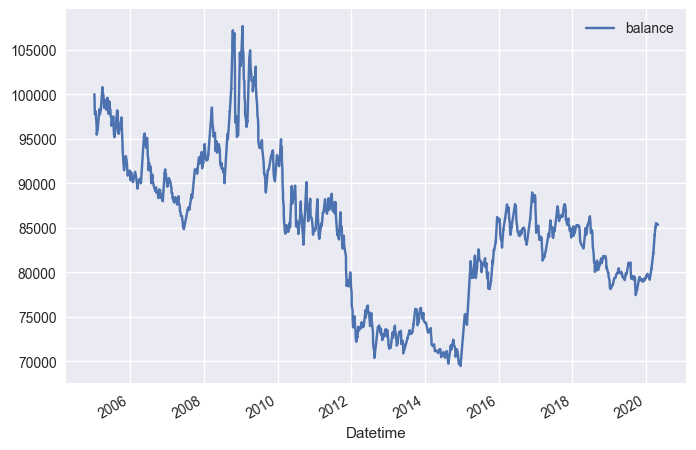

In [289]:
bc.balance_history['Datetime'] = pd.to_datetime(bc.balance_history['Datetime'])
bc.balance_history = bc.balance_history.set_index('Datetime')
bc.balance_history.plot()
plt.show()

In [290]:
bc.balance_history

,balance
Datetime,
2005-01-11 01:00:00,99994.281775
2005-01-12 22:00:00,98930.996897
2005-01-12 22:00:00,98925.399647
2005-01-15 23:00:00,97781.694897
2005-01-15 23:00:00,97744.379897
...,...
2020-04-08 22:00:00,85515.640693
2020-04-16 16:00:00,85308.202657
2020-04-16 16:00:00,85302.689877
